In [1]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import collections
import matplotlib.pylab as plt
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, roc_curve, average_precision_score, roc_auc_score
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

%cd /content/drive/MyDrive/DSGA_1006_Capstone/
from DataProcessing import DataClean, DataSeparation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1q394mIFN0E4pMJlGbnBgCugTrEkACfCy/DSGA_1006_Capstone


device(type='cpu')

## Get the data

In [ ]:
table_path = 'data/neural_net_all_yahoo_paring_scores_for_neural_net.csv'
data_clean = DataClean(table_path)

## GPT data
labeled_new = '/content/drive/MyDrive/DSGA_1006_Capstone/prompt_engineering/sample_label_1120.csv'
data_clean_new = DataClean(labeled_new)

In [ ]:
cols = pd.read_csv(table_path).iloc[:, :-1].drop(columns=['video_id']).columns
df_combined = pd.concat( [pd.read_csv(table_path).iloc[:, :-1].drop(columns=['video_id']),
                          pd.read_csv(labeled_new).iloc[:, 2:][cols]] )
df_combined.score = df_combined.score.apply( lambda x: 1 if x=='good' else 0 )

print( df_combined.post_id.nunique(), df_combined.video_post_id.nunique() , len(df_combined))

2703 1960 10879


In [ ]:
post_embeddings, video_embeddings, labels = data_clean.get_data()
post_embeddings_new, video_embeddings_new, labels_new = data_clean_new.get_data()

post_embeddings_update = np.concatenate((post_embeddings, post_embeddings_new), 0)
video_embeddings_update = np.concatenate((video_embeddings, video_embeddings_new), 0)
labels_update = np.concatenate((labels, labels_new), 0)

print(post_embeddings_update.shape, video_embeddings_update.shape, labels_update.shape)

(10879, 384) (10879, 384) (10879, 1)


In [ ]:
# map 'offensive' to 'bad'
labels_update = np.array([0 if label == 2 else int(label) for label in labels_update], dtype=object)
np.unique(labels_update, return_counts=True)

(array([0, 1], dtype=object), array([8253, 2626]))

## Dataset Class

In [ ]:
random_seed = 0
train_ratio = 0.8
validation_ratio = 0.1

dataseparation = DataSeparation(post_embeddings_update, video_embeddings_update, labels_update, train_ratio, validation_ratio, random_seed)
post_data, video_data, label_data, indices = dataseparation.get_data()

In [ ]:
class PostVideoPairDataset(Dataset):
    def __init__(self, post_embeddings, video_embeddings, labels):
        self.post_embeddings = post_embeddings
        self.video_embeddings = video_embeddings
        self.labels = labels

    def __len__(self):
        return self.post_embeddings.shape[0]

    def __getitem__(self, idx):
        post_embedding = self.post_embeddings[idx]
        video_embedding = self.video_embeddings[idx]
        label = self.labels[idx]

        data = {'post_embedding': torch.from_numpy(post_embedding).to(torch.float32).to(device),\
               'video_embedding': torch.from_numpy(video_embedding).to(torch.float32).to(device),\
               'label': torch.tensor(label).to(torch.int64).to(device)}

        return data

In [ ]:
train_dataset = PostVideoPairDataset(post_data['train'], video_data['train'], label_data['train'])
validation_dataset = PostVideoPairDataset(post_data['validation'], video_data['validation'], label_data['validation'])
test_dataset = PostVideoPairDataset(post_data['test'], video_data['test'], label_data['test'])

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size = 128, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = 129, shuffle = False)

## Neural Net

In [ ]:
class SimpleNeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNeuralNet, self).__init__()

        self.classification_tower = nn.Sequential(
                        nn.Linear(input_dim * 2, hidden_dim),
                        nn.ReLU(),
                        nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, post_embeddings, video_embeddings):

        combined = torch.cat((post_embeddings, video_embeddings), dim = 1)

        output = self.classification_tower(combined)

        return output



input_dim = 384
hidden_dim = 100
output_dim = 2
lr = 2e-4

# input_dim = 384
# hidden_dim = 64
# output_dim = 2
# lr = 1e-3

model = SimpleNeuralNet(input_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

## Evaluation using PR curve & ROC curve

In [ ]:
folds = 1000

def plot_roc_pr_ensemble_thresholds(model_probs_orig, y_test_orig, Name = 'train', EPOCH = None):
    mean_rec = np.linspace(0, 1, 10*len(y_test_orig))
    mean_fpr = np.linspace(0, 1, 10*len(y_test_orig))
    # print(y_test_orig.shape)
    # model_precision, model_recall, thresholds_orig = precision_recall_curve(y_test_orig, model_probs_orig)

    # majority_class = 1 if y_test_orig.sum() > 0.5*y_test_orig.shape[0] else 0
    # print('dummy model, simply predicting marjority class which is:', majority_class)

    # using half of the data for bootstrap
    pcnt_boot = 0.5

    ppvs = np.zeros((folds,  10*len(y_test_orig)), dtype=np.float32)
    tprs = np.zeros((folds,  10*len(y_test_orig)), dtype=np.float32)
    model_aps_list = []
    model_auc_list = []

    for epoch in range(folds):
        ix_subset = np.arange(len(y_test_orig))
        np.random.shuffle(ix_subset)
        ix_subset = ix_subset[0:int(pcnt_boot*len(y_test_orig))]

        y_test_i = y_test_orig[ix_subset]
        model_probs = model_probs_orig[ix_subset]

        model_precision, model_recall, thresholds = precision_recall_curve(y_test_i, model_probs)
        interp_prc = np.interp(mean_rec, model_recall[::-1], model_precision[::-1])

        ppvs[epoch, :] = interp_prc


        model_fpr, model_tpr, auc_thresholds = roc_curve(y_test_i, model_probs)
        interp_tpr = np.interp(mean_fpr, model_fpr, model_tpr)
        tprs[epoch, :] = interp_tpr

        model_aps = average_precision_score(y_test_i, model_probs)
        model_aps_list.append(model_aps)
        model_auc = roc_auc_score(y_test_i, model_probs)
        model_auc_list.append(model_auc)
    model_aps_list = np.array(model_aps_list)
    model_auc_list = np.array(model_auc_list)

    if Name is not None: ## only plot for test otherwise output too long
        plt.figure(figsize=(20,9))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)


        mean_ppv = ppvs.mean(axis=0)
        std_ppv = np.std(ppvs, axis=0)
        ppvs_upper = np.minimum(mean_ppv + std_ppv, 1) #1.96*(std_ppv)/np.sqrt(folds)
        ppvs_lower = np.maximum(mean_ppv - std_ppv, 0) #1.96*(std_ppv)/np.sqrt(folds)
        ax1.plot(mean_rec, ppvs.mean(axis=0).ravel(),
                label='Precision Recall Curve \nAverage Precision:{:.7f}[{:.7f} {:.7f}]'.format(
                    model_aps_list.mean(),
                    model_aps_list.mean() - 1.96*(model_aps_list.std())/np.sqrt(folds),
                    model_aps_list.mean() + 1.96*(model_aps_list.std())/np.sqrt(folds)
                ),
                alpha=1)
        ax1.fill_between(mean_rec, ppvs_lower, ppvs_upper, color='blue', alpha=.2,
                        label='Standard Deviation')

        ax1.set_xlabel('Recall (Sensitivity)',fontsize=18)
        ax1.set_ylabel('Precision (Positive Predictive Value)',fontsize=18)
        ax1.legend(loc="upper right",fontsize=14)
        ax1.grid()
        ax1.tick_params(axis="x", labelsize=14)
        ax1.tick_params(axis="y", labelsize=14)
        ax1.set_title('Precision Recall Curve', fontsize=18)


        mean_tpr = tprs.mean(axis=0)
        std_tpr = np.std(tprs, axis=0)
        #print(std_tpr)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1) #1.96*(std_tpr)/np.sqrt(folds)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)# 1.96*(std_tpr)/np.sqrt(folds)
        ax2.plot(mean_fpr, mean_tpr, label='ROC Curve \nAUC:{:.7f}[{:.7f} {:.7f}]'.format(
                    model_auc_list.mean(),
                    model_auc_list.mean() - 1.96*(model_auc_list.std())/np.sqrt(folds),
                    model_auc_list.mean() + 1.96*(model_auc_list.std())/np.sqrt(folds)
                ), alpha=1)
        ax2.fill_between(mean_fpr, tprs_lower, tprs_upper, color='blue', alpha=.2,
                        label='Standard Deviation')

        ax2.set_xlabel('False Positive Rate',fontsize=18)
        ax2.set_ylabel('True Positive Rate',fontsize=18)
        ax2.legend(loc="lower right",fontsize=14)
        ax2.grid()
        ax2.tick_params(axis="x", labelsize=14)
        ax2.tick_params(axis="y", labelsize=14)
        ax2.set_title('Receiver Operating Characteristic Curve', fontsize=18)

        ax1.set_xlim([0, 1.01])
        ax1.set_ylim([0, 1.01])
        ax2.set_xlim([0, 1.01])
        ax2.set_ylim([0, 1.01])

    # training process and validation process need to record which epoch we are in
    # test process does not need epoch
    if Name == 'train':
        path = '/content/drive/MyDrive/DSGA_1006_Capstone/Simple_Neural_Net/evaluation_plots/train/'
    elif Name == 'validation':
        path = '/content/drive/MyDrive/DSGA_1006_Capstone/Simple_Neural_Net/evaluation_plots/validation/'
    else:
        path = '/content/drive/MyDrive/DSGA_1006_Capstone/Simple_Neural_Net/evaluation_plots/test/'

    if EPOCH is not None:
        # train or validation
        print(str(EPOCH + 1))

        # fname = path + 'epoch_' + str(EPOCH+1) + '.png'
        # plt.savefig(fname)
    else:
        # test
        fname = path + 'test.png'
        plt.savefig(fname)
    plt.show()

    return mean_rec, ppvs.mean(axis=0).ravel(), model_aps_list.mean(), model_auc_list.mean()

## Train & Validation & Test

In [ ]:
log_interval = 5

def train(epoch):
    model.train()
    for batch_idx, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(data['post_embedding'], data['video_embedding'])
        loss = criterion(output, data['label'].squeeze())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data['post_embedding']), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item()))

In [ ]:
def validation(epoch):
    model.eval()
    validation_loss = 0
    true_labels = []
    pred_probs = []
    correct = 0

    for data in validation_dataloader:
        output = model(data['post_embedding'], data['video_embedding'])
        validation_loss += criterion(output, data['label'].squeeze()).cpu().item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(data['label'].view_as(pred)).cpu().sum()

        true_labels.extend(data['label'].squeeze().cpu().tolist())
        pred_probs.extend(F.softmax(output, dim = 1)[:, 1].squeeze().to('cpu').detach().tolist())


    true_labels = np.array(true_labels)
    pred_probs = np.array(pred_probs)

    validation_loss /= len(validation_dataloader.dataset)
    accu = 100. * correct / len(validation_dataloader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        validation_loss, correct, len(validation_dataloader.dataset), accu))

    recalls, precisions, avg_precision, avg_auc = plot_roc_pr_ensemble_thresholds(pred_probs, true_labels, 'validation', epoch)

    return recalls, precisions, avg_precision, avg_auc, accu

In [ ]:
def test():
    model.eval()
    test_loss = 0
    true_labels = []
    pred_probs = []
    correct = 0

    for data in test_dataloader:
        output = model(data['post_embedding'], data['video_embedding'])
        test_loss += criterion(output, data['label'].squeeze()).cpu().item()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(data['label'].view_as(pred)).cpu().sum()

        true_labels.extend(data['label'].squeeze().cpu().tolist())
        pred_probs.extend(F.softmax(output, dim = 1)[:, 1].squeeze().to('cpu').detach().tolist())

    true_labels = np.array(true_labels)
    pred_probs = np.array(pred_probs)

    test_loss /= len(test_dataloader.dataset)
    accu = 100. * correct / len(test_dataloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset), accu))

    recalls, precisions, avg_precision, avg_auc = plot_roc_pr_ensemble_thresholds(pred_probs, true_labels, 'test')

    return recalls, precisions, avg_precision, avg_auc, accu


Validation set: Average loss: 0.0054, Accuracy: 850/1088 (78.12%)

0


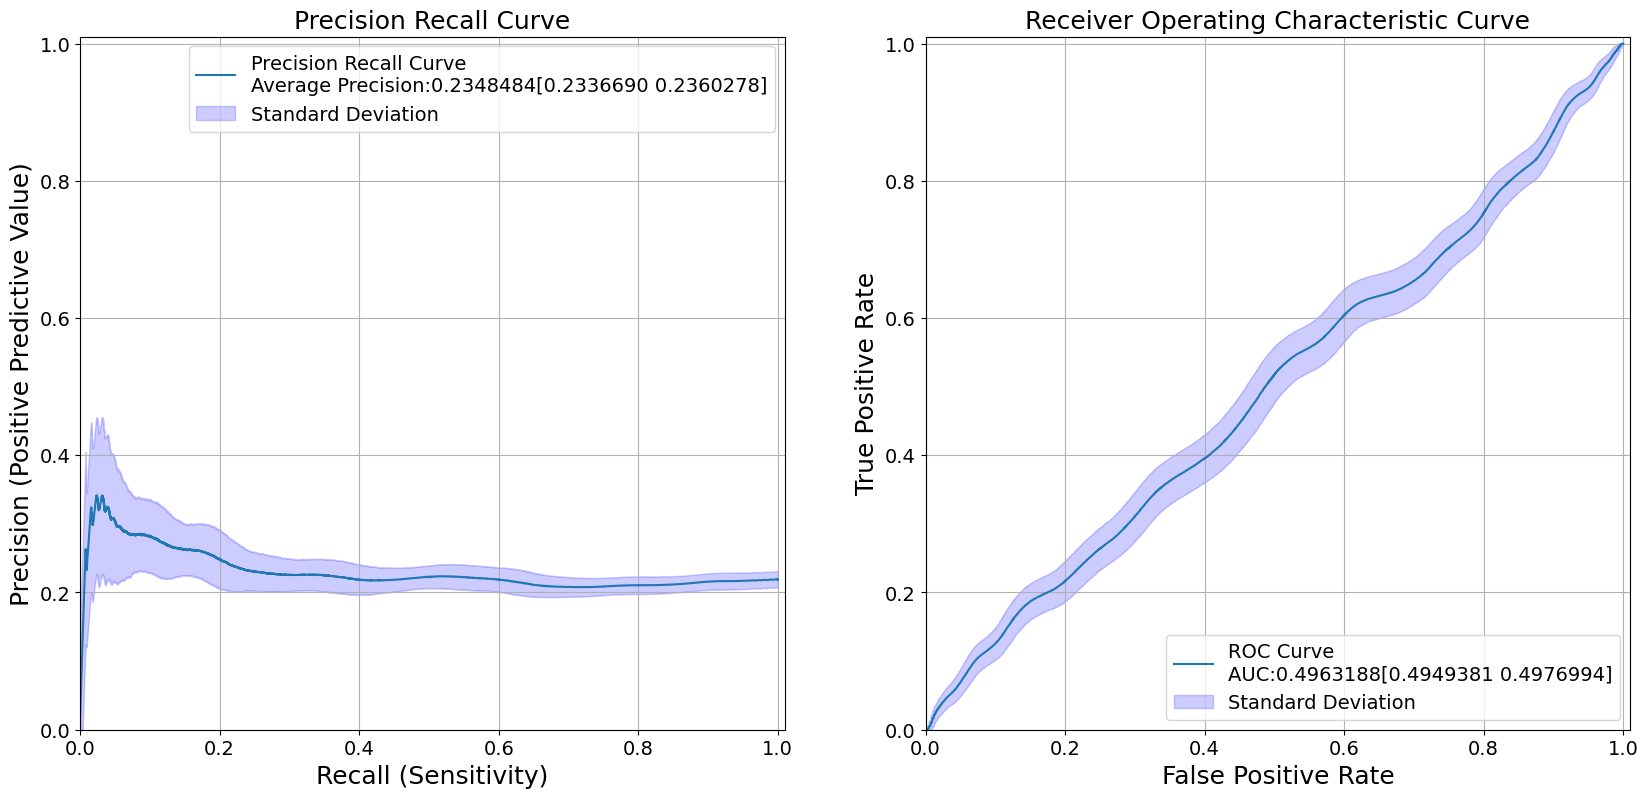

In [ ]:
# initial model on validation set
recalls, precisions, avg_precision, avg_auc, accu = validation(-1)


Test set: Average loss: 0.0054, Accuracy: 791/1088 (72.70%)



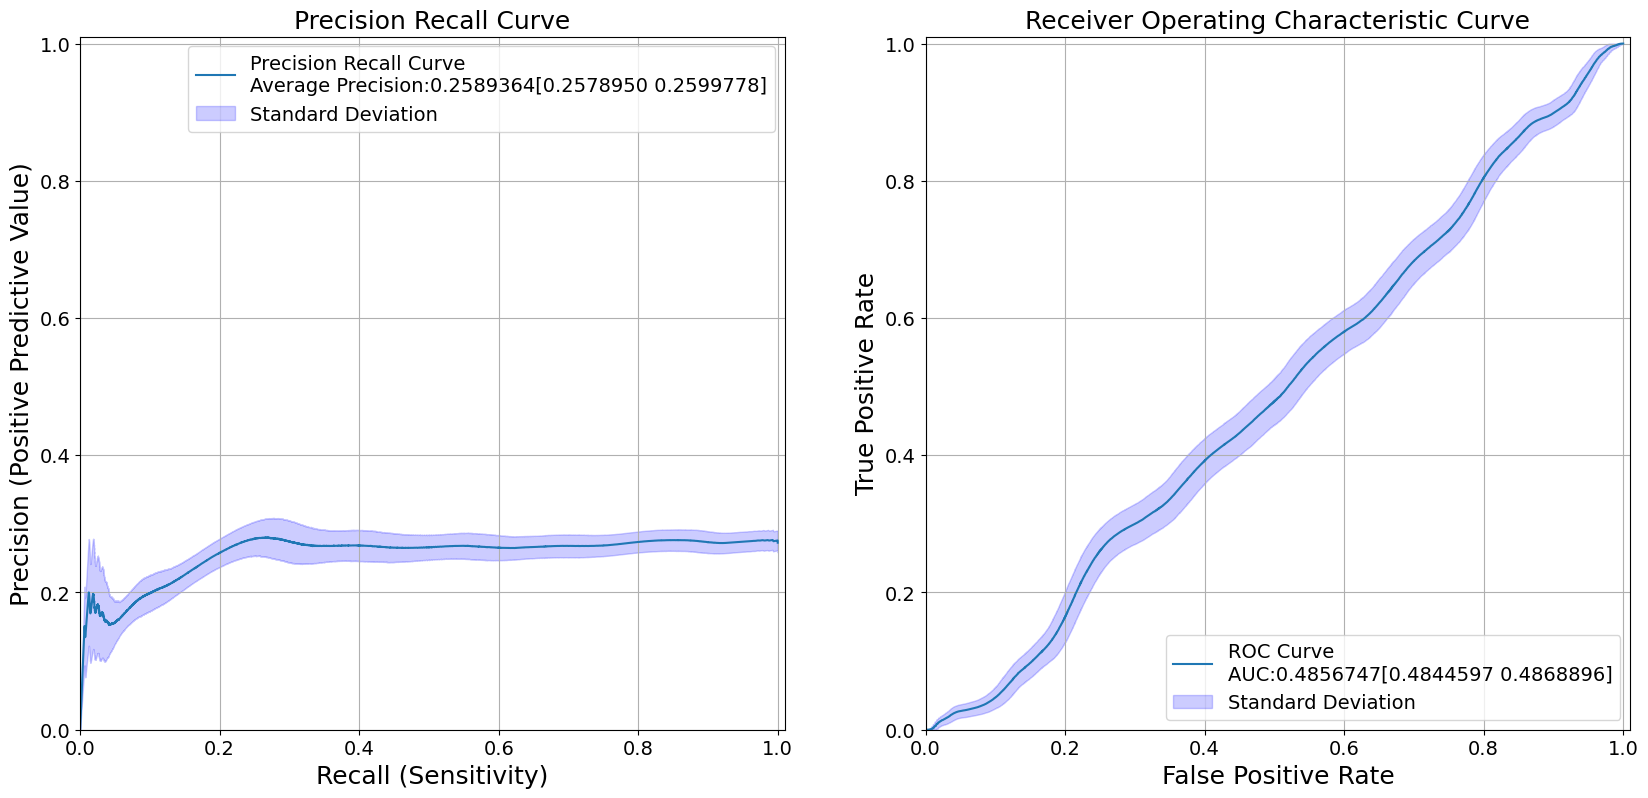

In [ ]:
# initial model on test set
recalls, precisions, avg_precision, avg_auc, accu = test()

In [ ]:
# train the model

epochs = 150
avg_precisions = []
max_avg_precision = 0.0
avg_aucs = []
accuracies = []

#max_accu = 0.0
for epoch in range(epochs):
    train(epoch)
    recalls, precisions, avg_precision, avg_auc, accu = validation(epoch)
    avg_precisions.append(avg_precision)
    avg_aucs.append(avg_auc)
    accuracies.append(accu)

    # save the model with the best accuracy on validation set
    if epoch == 0:
        max_avg_precision = avg_precision
        torch.save(model, '/content/drive/MyDrive/DSGA_1006_Capstone/Simple_Neural_Net/model_save/best_model_val.pt')
    elif epoch > 0:
        if avg_precision > max_avg_precision:
            max_avg_precision = avg_precision
            torch.save(model, '/content/drive/MyDrive/DSGA_1006_Capstone/Simple_Neural_Net/model_save/best_model_val.pt')

Output hidden; open in https://colab.research.google.com to view.


Test set: Average loss: 0.0051, Accuracy: 867/1088 (79.69%)



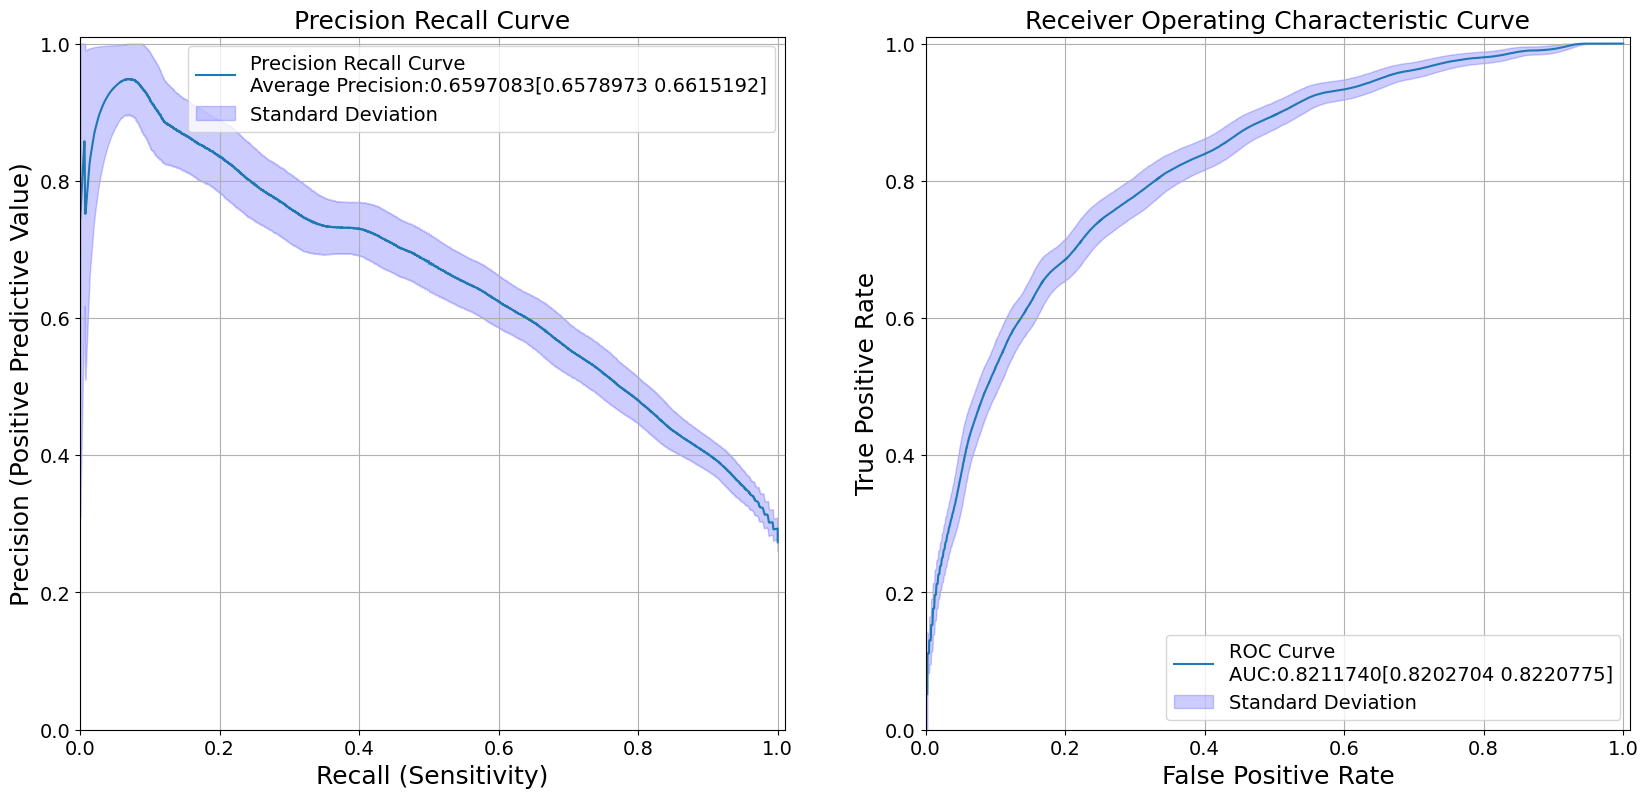

In [ ]:
model = torch.load('/content/drive/MyDrive/DSGA_1006_Capstone/Simple_Neural_Net/model_save/best_model_val.pt')
recalls, precisions, avg_precision, avg_auc, accu = test()

Text(0.5, 1.0, 'Precisions')

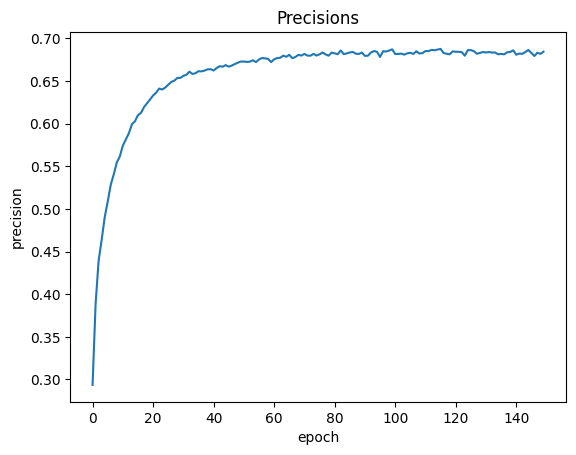

In [ ]:
plt.plot(avg_precisions)
plt.xlabel('epoch')
plt.ylabel('precision')
plt.title('Precisions')

Text(0.5, 1.0, 'AUCs')

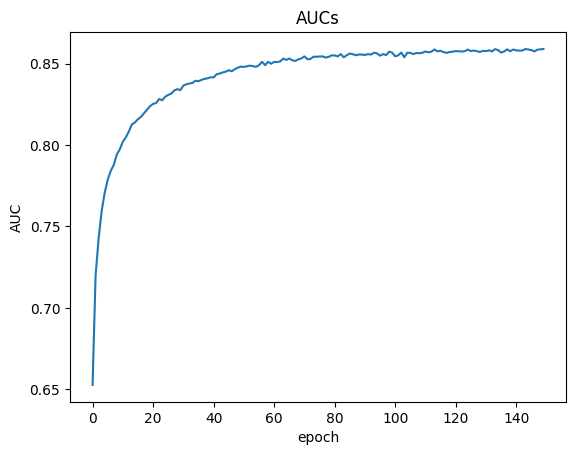

In [ ]:
plt.plot(avg_aucs)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUCs')

Text(0.5, 1.0, 'Accuracies')

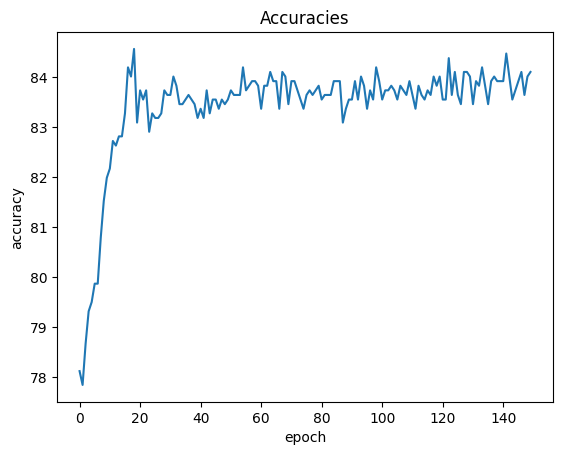

In [ ]:
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracies')

# Model Evaluation

## Top1 recommendation

In [ ]:
# v1: new version
model_v1 = torch.load('/content/drive/MyDrive/DSGA_1006_Capstone/Simple_Neural_Net/model_save/best_model_val.pt')
# v2: original version
model_v2 = torch.load('/content/drive/MyDrive/DSGA_1006_Capstone/Simple_Neural_Net/model_save/original_best_model_val.pt')

In [ ]:
# df = pd.read_csv(table_path)
import ast

article_embeds = pd.read_csv('data/content_embeds/content_embeds.csv.gz', compression='gzip')
video_embeds = pd.read_csv('data/video_embeds/video_embeds.csv.gz', compression='gzip')

np.random.seed(0)
shuffled_indices = np.random.permutation(article_embeds.index)

article_embeds = article_embeds.iloc[shuffled_indices,:][['TITLE','EMBED']].reset_index(drop=True)

all_article_embeds = article_embeds.EMBED.apply(lambda x: ast.literal_eval(x))
all_article_embeds = np.array(all_article_embeds.tolist()).squeeze(1)

all_video_embeds = video_embeds.EMBED.apply(lambda x: ast.literal_eval(x))
all_video_embeds = np.array(all_video_embeds.tolist()).squeeze(1)

all_article_embeds.shape, all_video_embeds.shape

((23558, 384), (6387, 384))

In [ ]:
## Generate scores of all videos for every article
num_article, num_video = len(all_article_embeds), len(all_video_embeds)
video_emb = torch.tensor(all_video_embeds).float().to(device)

scores_v1 = torch.zeros((num_article, num_video))
scores_v2 = torch.zeros((num_article, num_video))

model_v1 = model_v1.to(device)
model_v2 = model_v2.to(device)

batch_size = 64

with torch.no_grad():
  for i in range(0, num_article, batch_size):
      end_idx = min(i + batch_size, num_article)
      batch_article_emb = torch.tensor(all_article_embeds[i:end_idx]).float().to(device)

      # (batch_size * num_video, 384)
      article_emb = batch_article_emb.repeat(num_video, 1)

      output_v1 = model_v1(article_emb, video_emb.repeat(batch_article_emb.shape[0], 1))
      batch_scores_v1 = F.softmax(output_v1, dim=1)[:, 1].view(batch_article_emb.shape[0], num_video)

      # save the score
      scores_v1[i:end_idx] = batch_scores_v1.cpu()  # move back to cpu

      output_v2 = model_v2(article_emb, video_emb.repeat(batch_article_emb.shape[0], 1))
      batch_scores_v2 = F.softmax(output_v2, dim=1)[:, 1].view(batch_article_emb.shape[0], num_video)

      # save the score
      scores_v2[i:end_idx] = batch_scores_v2.cpu()  # move back to cpu

      torch.cuda.empty_cache()

# top 1 recommendation
recommend_score_v1, recommend_idx_v1 = torch.max(scores_v1, dim=1)
recommend_score_v2, recommend_idx_v2 = torch.max(scores_v2, dim=1)

In [ ]:
# results = {
#     'article_title': article_embeds['TITLE'].tolist(),
#     'video_title_v1': video_embeds.iloc[recommend_idx_v1, :]['TITLE'].tolist(),
#     'score_v1': recommend_score_v1.detach().cpu(),
#     'video_title_v2': video_embeds.iloc[recommend_idx_v2, :]['TITLE'].tolist(),
#     'score_v2': recommend_score_v2.detach().cpu(),
# }
# df_results = pd.DataFrame(results)
# df_results

In [ ]:
# file_path = '/content/drive/MyDrive/DSGA_1006_Capstone/prompt_engineering/best_model_pile_up.csv'
# df_results.to_csv(file_path, mode='a', header=df_results.columns, index=False)

In [ ]:
# from collections import Counter
# Counter( recommend_idx_v1.cpu().numpy() ).most_common(30)

In [ ]:
# len(np.unique(np.array(recommend_idx)))

### test code

In [ ]:
top5_scores, top5_indices = torch.topk(scores, 10, dim=1) #5/10
top5_scores[:20], top5_indices[:20], torch.unique(top5_indices[:20].flatten()).shape

(tensor([[0.9983, 0.9945, 0.9942, 0.9937, 0.9926, 0.9922, 0.9919, 0.9918, 0.9886,
          0.9876],
         [0.9982, 0.9975, 0.9968, 0.9948, 0.9947, 0.9943, 0.9937, 0.9934, 0.9932,
          0.9931],
         [0.9972, 0.9956, 0.9954, 0.9949, 0.9946, 0.9936, 0.9935, 0.9924, 0.9914,
          0.9907],
         [0.9980, 0.9974, 0.9973, 0.9971, 0.9966, 0.9942, 0.9935, 0.9928, 0.9922,
          0.9905],
         [0.9989, 0.9977, 0.9969, 0.9959, 0.9957, 0.9954, 0.9950, 0.9947, 0.9929,
          0.9923],
         [0.9985, 0.9976, 0.9974, 0.9971, 0.9966, 0.9962, 0.9947, 0.9935, 0.9934,
          0.9922],
         [0.9970, 0.9947, 0.9941, 0.9938, 0.9923, 0.9922, 0.9921, 0.9912, 0.9911,
          0.9906],
         [0.9985, 0.9983, 0.9961, 0.9948, 0.9931, 0.9918, 0.9912, 0.9904, 0.9898,
          0.9877],
         [0.9992, 0.9969, 0.9960, 0.9956, 0.9945, 0.9944, 0.9936, 0.9932, 0.9929,
          0.9924],
         [0.9993, 0.9989, 0.9978, 0.9975, 0.9974, 0.9967, 0.9955, 0.9923, 0.9920,
         

In [ ]:
#???
df = pd.concat( [pd.read_csv(table_path).iloc[:, :-1].drop(columns=['video_id']),
            pd.read_csv(labeled_new).iloc[:, 2:][cols]] )#.shape


In [ ]:
pd.set_option('display.max_colwidth', None)
## Generate a new df with article title, recommended video title, score
df_to_eval = df #df.loc[indices['validation'][:150], ['post_title']].reset_index(drop=True)
df_to_eval['video_title'] = video_embeds.loc[recommend_idx, ['TITLE']].reset_index(drop=True)
df_to_eval['score'] = recommend_score.detach().numpy()
df_to_eval['human_label'] = 0 # requires manual labeling

ValueError: ignored

In [ ]:
## Specific classes to classify
## Ask GPT4 to generate rating 1-10 for new pairs, 50 pairs each time. Ran 3 times here

Question = "Please rate each (Article Title, Video Title) pair from 1 to 10, where 1 represents totally unmatch, 10 represents perfect match. Try to rate based on how appropriate it is to embed the video into the article in oneline media website. Please focus on high level information such as Subjects, Verticals, Domains, etc. If one of the titles is related to business, law, news or politics, the other one should lie within the same Vertical. Please output a python list of ratings in integer."

# for i in range(101, 150):
#     Question += f"Article Title {i}: {df_to_eval.loc[i, 'post_title']}; Video Title {i}: {df_to_eval.loc[i, 'video_title']}\n\n"
Question[:-2]

In [ ]:
ratings_0_50 = [
    1, # 0: Different subjects, not related
    3, # 1: Both related to COVID but from different angles and countries
    1, # 2: One is about Hollywood and the other about heights, not related
    5, # 3: Both related to places and experiences but not directly related
    8, # 4: Both related to Russia and political actions
    9, # 5: Both related to cruises and specifically Virgin Voyages
    9, # 6: Both related to flight cancellations and delays
    4, # 7: Both about Elon Musk but different topics
    2, # 8: Both about technology but not directly related
    1, # 9: One about a TV show and the other about heights, not related
    1, # 10: One about Nick Cave's opinion and the other about heights, not related
    7, # 11: Both related to technology and market dynamics
    3, # 12: Both related to young achievers but in different fields
    1, # 13: One about Tiger Woods and the other about heights, not related
    4, # 14: Both about business figures and their companies but not directly related
    4, # 15: Both about political actions but not directly related
    1, # 16: One about fitness and the other about animals, not related
    6, # 17: Both related to political actions and impacts
    6, # 18: Both about market dynamics but different subjects
    2, # 19: Both about US economy but different angles
    4, # 20: Both related to young achievers but in different contexts
    2, # 21: One about a transformed train and the other about restaurants, not directly related
    7, # 22: Both related to the finance sector
    5, # 23: Both about Elon Musk's companies but not directly related
    7, # 24: Both about market dynamics and potential frauds
    7, # 25: Both about market dynamics and potential frauds
    4, # 26: Both about influential business figures but not directly related
    6, # 27: Both related to market dynamics and potential downturns
    4, # 28: Both about Elon Musk and his businesses but not directly related
    3, # 29: Both political but different subjects
    6, # 30: Both related to car industries but different companies
    5, # 31: Both about criminal actions but different contexts
    4, # 32: Both related to young achievers but not directly related
    4, # 33: Both related to political figures but different subjects
    6, # 34: One about a personal experience and the other a cruise ship experience
    6, # 35: Both related to business dynamics and potential failures
    8, # 36: Both related to military actions and Russia's involvement
    4, # 37: Both about food experiences but from different countries
    7, # 38: Both about market dynamics and potential frauds
    7, # 39: Both about market dynamics and potential frauds
    7, # 40: Both about controversial figures and potential frauds
    4, # 41: Both about food experiences but different contexts
    7, # 42: Both about market dynamics and potential frauds
    7, # 43: Both about potential criminal actions
    6, # 44: Both about innovative vehicles but different kinds
    6, # 45: Both related to crypto and potential financial issues
    7, # 46: Both about market dynamics and potential downturns
    10, # 47: Both about weight loss myths
    3, # 48: One about a sports team's performance and the other about unexpected predators
    7, # 49: Both about political actions and potential controversies
    4  # 50: One about a movie's deviation from reality and the other about a young achiever
]
ratings_51_100 = [
    10,  # 51: Both focus on Sam Bankman-Fried and a scandal.
    4,   # 52: Both relate to Disney but focus on different aspects.
    2,   # 53: One is about Microsoft's AI and the other is about blockchain.
    1,   # 54: Truffle hunting vs. effects of alcohol on the brain.
    1,   # 55: Incident involving Dana White vs. details from "Westworld".
    1,   # 56: Tesla accident vs. blockchain misconceptions.
    2,   # 57: AI in medical field vs. unexpected predatory animals.
    9,   # 58: Both focus on conflict between Russia and Ukraine.
    1,   # 59: Celebrities' zodiac signs vs. places for thrill-seekers.
    7,   # 60: Both focus on events related to Russia's actions in conflict.
    1,   # 61: Goldman Sachs layoffs vs. Sam Bankman-Fried scandal.
    1,   # 62: Russian arms dealer and Ukraine vs. escaping fugitive.
    1,   # 63: Restrictions on SNAP purchases vs. one-size-fits-all jeans.
    1,   # 64: "Sister Wives" moments vs. misconceptions about blockchain.
    1,   # 65: Gingerbread cookies vs. unique activities in Japan.
    4,   # 66: Senate majority in 2024 vs. Biden's reelection and Trump's reaction.
    2,   # 67: Disrupted cruise vs. places for thrill-seekers.
    1,   # 68: Wall Street's opinion on inflation vs. Sam Bankman-Fried scandal.
    1,   # 69: University of Idaho incident vs. escaping fugitive.
    1,   # 70: Sanders on student loans vs. Sam Bankman-Fried scandal.
    9,   # 71: Both focus on Russian soldiers in conflict with Ukraine.
    3,   # 72: TikTok fashion trends vs. one-size-fits-all jeans.
    10,  # 73: Both focus on Sam Bankman-Fried and his legal troubles.
    1,   # 74: Elon Musk's opinion on Fed's action vs. Sam Bankman-Fried scandal.
    10,  # 75: Both discuss Sam Bankman-Fried's issues in the finance world.
    1,   # 76: Celebrity death pranks vs. fearsome animals.
    4,   # 77: Fashion trends vs. unique heels for celebrities.
    7,   # 78: Profiles of young finance professionals.
    4,   # 79: Personal experiences in the film industry vs. profile of a young NYSE broker.
    9,   # 80: Both relate to flight disruptions and airport issues.
    1,   # 81: Russian space mission vs. Sam Bankman-Fried scandal.
    7,   # 82: Both relate to political dynamics in the US House of Representatives.
    1,   # 83: Major oil spills vs. places for thrill-seekers.
    1,   # 84: Hot cocoa taste test vs. unique activities in Japan.
    5,   # 85: Russian military threats vs. Russian military actions in Ukraine.
    1,   # 86: Sneaker trends vs. places for thrill-seekers.
    1,   # 87: Non-alcoholic beers vs. an adults-only cruise ship.
    2,   # 88: Home-cooked food benefits vs. a unique restaurant in NYC.
    1,   # 89: Insights from "A Christmas Story" vs. fearsome animals.
    8,   # 90: Both relate to the January 6th Capitol incident.
    1,   # 91: Conflict in the finance world vs. Sam Bankman-Fried scandal.
    4,   # 92: Fake educational background vs. profile of a young NYSE broker.
    1,   # 93: US Congress behavior vs. misconceptions about blockchain.
    1,   # 94: Twitter's financial performance vs. Jeff Bezos' space ambitions.
    1,   # 95: Berkshire Hathaway's stock performance vs. misconceptions about blockchain.
    8,   # 96: Both relate to criminal incidents.
    9,   # 97: Both focus on Russian actions and their implications.
    1,   # 98: Teamsters' negotiations vs. places for thrill-seekers.
    2,   # 99: Cardi B's personal experiences vs. debunking mental-health myths.
    1    # 100: New Alzheimer's drug vs. one-size-fits-all jeans.
]
ratings_101_150 = [
    1, # 101
    1, # 102
    6, # 103
    4, # 104
    4, # 105
    2, # 106
    1, # 107
    2, # 108
    1, # 109
    2, # 110
    8, # 111
    4, # 112
    7, # 113
    1, # 114
    2, # 115
    9, # 116
    2, # 117
    2, # 118
    5, # 119
    2, # 120
    3, # 121
    3, # 122
    6, # 123
    8, # 124
    2, # 125
    2, # 126
    1, # 127
    1, # 128
    1, # 129
    6, # 130
    1, # 131
    1, # 132
    7, # 133
    1, # 134
    1, # 135
    1, # 136
    1, # 137
    2, # 138
    5, # 139
    2, # 140
    1, # 141
    2, # 142
    2, # 143
    1, # 144
    6, # 145
    2, # 146
    1, # 147
    2, # 148
    4  # 149
]

ratings = ratings_0_50 + ratings_51_100 + ratings_101_150
df_to_eval['GPT_score'] = ratings
# df_to_eval

In [ ]:
human_label_0_50 = [
    0, 0, 0, 0, 1,
    1, 1, 0, 0, 0,
    0, 1, 0, 0, 0,
    0, 0, 0, 0, 0,
    0, 0, 0, 0, 0,
    1, 0, 0, 0, 0,
    0, 0, 0, 0, 0,
    0, 1, 0, 1, 0,
    0, 0, 0, 0, 0,
    1, 0, 1, 0, 0
]

df_to_eval.loc[:49, 'human_label'] = human_label_0_50
df_to_eval.head(20)

In [ ]:
df_to_eval['GPT_label'] = df_to_eval.GPT_score.apply(lambda x: 1 if x >=4 else 0)
df_to_eval

### compute rates on validation set

θ is 0.02, Matching rate is 0.5082720588235294 and Quality rate is 0.38155515370705245
θ is 0.04, Matching rate is 0.44669117647058826 and Quality rate is 0.4218106995884774
θ is 0.06, Matching rate is 0.40441176470588236 and Quality rate is 0.44772727272727275
θ is 0.08, Matching rate is 0.37775735294117646 and Quality rate is 0.46958637469586373
θ is 0.1, Matching rate is 0.36121323529411764 and Quality rate is 0.48346055979643765
θ is 0.12, Matching rate is 0.3492647058823529 and Quality rate is 0.4921052631578947
θ is 0.14, Matching rate is 0.3327205882352941 and Quality rate is 0.5027624309392266
θ is 0.16, Matching rate is 0.32536764705882354 and Quality rate is 0.5141242937853108
θ is 0.18, Matching rate is 0.31525735294117646 and Quality rate is 0.5247813411078717
θ is 0.2, Matching rate is 0.3079044117647059 and Quality rate is 0.5313432835820896
θ is 0.22, Matching rate is 0.29503676470588236 and Quality rate is 0.5482866043613707
θ is 0.24, Matching rate is 0.283088235294117

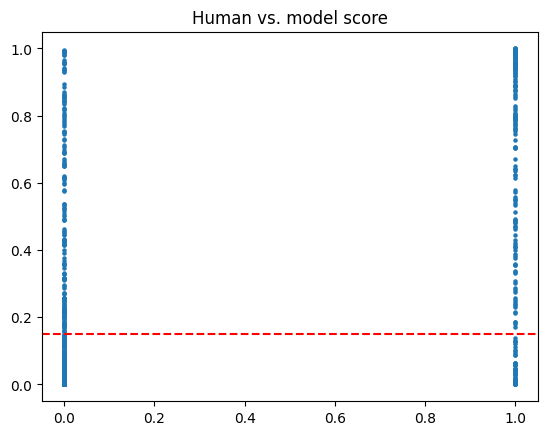

In [ ]:
## Generate 6387 scores for every article
# scores = torch.zeros((150, num_video))
# video_emb = torch.tensor(all_video_embeds).float()

# for idx, article in enumerate(validation_article_emb):
#     ## Emb of each article, repeated 6,387 times to vectorize
#     article_emb = torch.tensor(article).unsqueeze(0).repeat(num_video, 1).float()
#     ## Get score of each (article_i, video_j) pair
#     output = model(article_emb, video_emb)
#     ## map to probability
#     scores[idx] = F.softmax(output, dim=1)[:, 1]

# ## Get idx and highest score of the video for each article
# recommend_score, recommend_idx = torch.max(scores, dim=1)


out, labels = np.array([]), np.array([])
for idx, elem in enumerate(validation_dataloader):
    article_emb, video_emb, label = elem['post_embedding'], elem['video_embedding'], elem['label']

    # print( f"model result is {torch.topk( F.softmax(model(article_emb, video_emb), dim=1)[:, 1], 2)[0][1] }" )
    out = np.append( out, F.softmax(model(article_emb, video_emb), dim=1)[:, 1].detach().numpy() )
    # out = np.append( out, torch.topk( F.softmax(model(article_emb, video_emb), dim=1)[:, 1], 2)[0][1].detach().numpy() )
    labels = np.append( labels, label.detach().numpy() )

# print(out, labels)
df_val = pd.DataFrame({'score': out, 'label': labels})

plt.scatter(x=df_val.label, y=df_val.score, s=5)
plt.title(f"Human vs. model score")
plt.axhline(y = 0.15, color = 'r', linestyle = '--')

for theta in range(2, 100, 2):
    theta /= 100
    print(f"θ is {theta}, Matching rate is {np.mean(df_val.score >= theta)} and Quality rate is {np.mean( df_val[df_val.score >= theta].label == 1 )}")

In [ ]:
# plt.scatter(x=df_to_eval.GPT_label, y=df_to_eval.score, s=5)
# plt.axhline(y = 0.88, color = 'r', linestyle = '--')

# for theta in [.7, .75, .8, .83, .85, .88, .90]:
#     print(f"θ is {theta}, Matching rate is {np.mean(df_to_eval.score >= theta)} and Quality rate is {np.mean( df_to_eval[df_to_eval.score >= theta].GPT_label == 1 )}")

NameError: ignored

In [ ]:
## Generate 6387 scores for every article
scores = torch.zeros((150, num_video))
video_emb = torch.tensor(all_video_embeds).float()

for idx, article in enumerate(validation_article_emb):
    ## Emb of each article, repeated 6,387 times to vectorize
    article_emb = torch.tensor(article).unsqueeze(0).repeat(num_video, 1).float()
    ## Get score of each (article_i, video_j) pair
    output = model(article_emb, video_emb)
    ## map to probability
    scores[idx] = F.softmax(output, dim=1)[:, 1]

## Get idx and highest score of the video for each article
recommend_score, recommend_idx = torch.max(scores, dim=1)

NameError: ignored

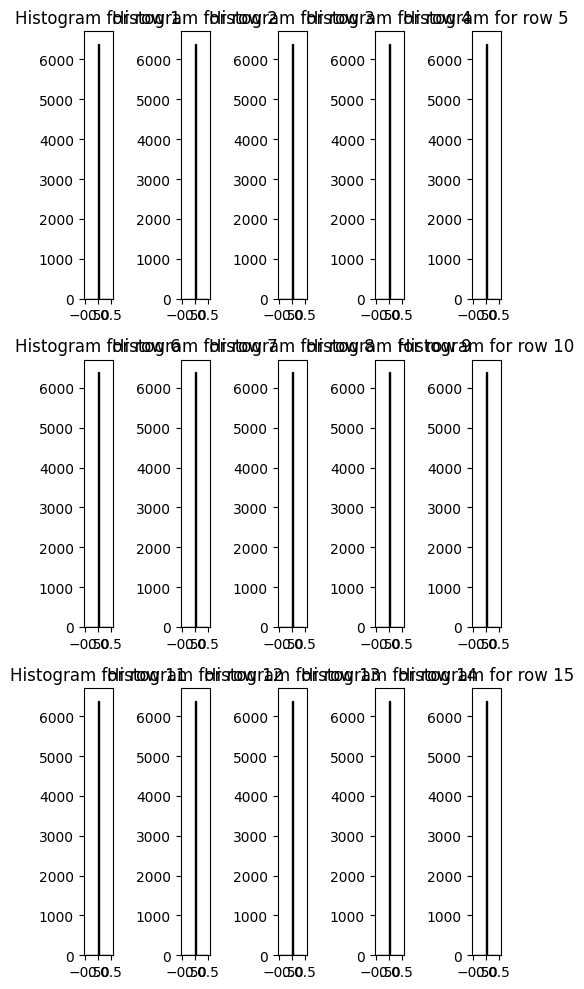

In [ ]:
# import matplotlib.pyplot as plt

# plt.hist( np.log(scores[145, :].detach().numpy()), bins=50 )

# max(scores[145].detach().numpy()), min( scores[145].detach().numpy() )
import numpy as np
import matplotlib.pyplot as plt

# Set up the figure and the grid of subplots
n_rows = 3
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5, 10))  # Adjust the figsize as needed

# For each row in the scores matrix
for idx, row in enumerate(scores[:15]):
    ax = axes[idx // n_cols, idx % n_cols]
    ax.hist(row.detach().numpy(), bins=50, color='skyblue', edgecolor='black')
    ax.set_title(f"Histogram for row {idx+1}")

plt.tight_layout()
plt.show()


In [ ]:
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score
# from sklearn.metrics import confusion_matrix
# from collections import defaultdict

# human_scores = pairs.loc[51:200, 'score'].values
# ## Put a default list, key is θ, value is list of stats
# dic_cutoffs = defaultdict(list)
# ## Iteratively find best θ to maximize Accuracy and F1-score
# for Theta in range(1, 11, 1):
#     GPT_scores = ratings_51_100 + ratings_101_150 + ratings_151_200
#     GPT_scores = np.array( list(map(lambda x: 1 if x >= Theta else 0, GPT_scores)) )

#     accuracy = accuracy_score(GPT_scores, human_scores)
#     precision = precision_score(GPT_scores, human_scores)
#     recall = recall_score(GPT_scores, human_scores)
#     F1 = f1_score(GPT_scores, human_scores)

#     dic_cutoffs[Theta] = [Theta, accuracy, precision, recall, F1]

# stats = list(dic_cutoffs.values()) ## Get dictionary values
# sorted(stats, key=lambda x: x[-1], reverse=True)

# ## 4 or 6 is the best cutoff here

In [ ]:
# probability/calibration
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

pertrue, predprob = calibration_curve(y_test.values, probs[:, 1], n_bins=10)
g = sns.scatterplot(x=predprob, y=pertrue)
g = (g.set(ylim=(0, 1)))
pl.plot([0, 1], [0, 1], color='r', alpha=.3)

## Brier score + Calibration
https://stats.stackexchange.com/questions/597679/how-does-the-brier-score-break-down-to-reliability-resolution-uncertainty

https://timvangelder.com/2015/05/18/brier-score-composition-a-mini-tutorial/

https://en.wikipedia.org/wiki/Brier_score

https://towardsdatascience.com/intuition-behind-log-loss-score-4e0c9979680a

In [2]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

df_all = pd.read_csv('prompt_engineering/sample_2000_labels_combined.csv', index_col=0)
label_columns = ['real_v1_threshold_1','real_v1_threshold_2','real_v1_threshold_3','real_v1_threshold_4','real_v1_threshold_5','real_v1_threshold_6',\
                 'real_v2_threshold_1','real_v2_threshold_2','real_v2_threshold_3','real_v2_threshold_4','real_v2_threshold_5','real_v2_threshold_6']
for column in label_columns:
  df_all[column] = df_all[column].apply(lambda x: 1 if x == 'good' else 0)
df_all.head()

,article_title,video_title_v1,score_v1,video_title_v2,score_v2,real_v1_threshold_1,real_v1_threshold_2,real_v1_threshold_3,real_v1_threshold_4,real_v1_threshold_5,real_v1_threshold_6,real_v2_threshold_1,real_v2_threshold_2,real_v2_threshold_3,real_v2_threshold_4,real_v2_threshold_5,real_v2_threshold_6
0,Social media managers are blaming Elon Musk fo...,How Tesla's Model Y compares to Ford's first EV,0.998296,How Tesla's Model Y compares to Ford's first EV,0.999991,1,1,1,1,1,0,1,1,1,1,1,0
1,Putin may have set a trap for Wagner fighters ...,28 of the best foods that you have to try in 2021,0.998186,40 LA restaurants you need to try,0.999809,1,0,0,0,0,0,1,0,0,0,0,0
2,Best Bank Accounts for International Travel of...,This warehouse is full of horror movie props,0.997214,14 reasons to visit the Hawaiian islands,0.999407,1,0,0,0,0,0,1,1,0,0,0,0
3,38 celebrities who have been open about their ...,How Publishers Clearing House makes $1 billion...,0.998005,The rise and fall of the American mall,0.999778,1,1,0,0,0,0,1,1,1,1,1,0
4,"It costs up to $3,400 to experience magic mush...",Take a look inside the shop that creates extre...,0.998867,How Tesla's Model Y compares to Ford's first EV,0.999816,1,1,0,0,0,0,1,1,0,0,0,0


In [3]:
def brier_score_calibration(df, model_version, threshold, n_bins=20):
  ## retrieve labels and scores
  assert model_version in [1, 2]
  assert threshold in [1, 2, 3, 4, 5, 6]
  print(f'model=v_{model_version}; threshold={threshold}')

  true_labels = df[[f'real_v{model_version}_threshold_{threshold}']].to_numpy()
  pred_probs = df[[f'score_v{model_version}']].to_numpy()

  # ## the Brier score
  # brier = brier_score_loss(true_labels, pred_probs)
  # print(f"Brier Score: {brier:.4f}")
  ## Brier score decomposition: score = Reliability - resolution + uncertainty

  ## Create the bins for grouping predicted probabilities
  bin_thresholds = np.linspace(0, 1, n_bins + 1)
  bins = np.digitize(pred_probs, bin_thresholds[1:-1]) # p in (0,1)

  ## Calculate the components
  # Initialize variables
  total = len(true_labels)
  reliability = 0.0
  resolution = 0.0
  uncertainty = np.var(true_labels)  # Uncertainty: variance of the true labels
  prob_true, prob_pred, counts = np.zeros(n_bins), np.zeros(n_bins), np.zeros(n_bins)

  # Compute bin averages and counts
  for i in range(total):
      bin_idx = bins[i]
      prob_true[bin_idx] += true_labels[i]
      prob_pred[bin_idx] += pred_probs[i]
      counts[bin_idx] += 1

  # Avoid division by zero; if a bin is empty, skip
  non_empty_bins = counts > 0

  # Computation of averages
  prob_true[non_empty_bins] /= counts[non_empty_bins]
  prob_pred[non_empty_bins] /= counts[non_empty_bins]

  # Overall average of true labels
  average_prob_true = np.mean(true_labels)

  # Calculate reliability and resolution
  for bin_idx in range(n_bins):
      if counts[bin_idx] > 0:
          # Reliability: weighted sum of (prob - label)^2
          reliability += counts[bin_idx] * (prob_pred[bin_idx] - prob_true[bin_idx]) ** 2
          # Resolution: weighted sum of (label - avg_label)^2
          resolution += counts[bin_idx] * (prob_true[bin_idx] - average_prob_true) ** 2
  reliability /= total
  resolution /= total

  # Calculate the Brier score and its components
  brier_score = reliability - resolution + uncertainty
  components = (reliability, resolution, uncertainty)

  print(f"Brier Score: {brier_score}")
  print(f"Components: Reliability={reliability}, Resolution={resolution}, Uncertainty={uncertainty}")

  ## Calibratio plot

  # Generating a calibration curve
  fraction_of_positives, mean_predicted_value = calibration_curve(true_labels, pred_probs, n_bins=n_bins, strategy='uniform')

  # Calculate the bin sizes by grouping the probabilities
  bin_size = np.zeros(len(mean_predicted_value))
  for prob in pred_probs:
      for i in range(len(mean_predicted_value)-1):
          if mean_predicted_value[i] <= prob < mean_predicted_value[i+1]:
              bin_size[i] += 1
              break
      else:
          if prob <= mean_predicted_value[0]:
              bin_size[0] += 1
          elif prob >= mean_predicted_value[-1]:
              bin_size[-1] += 1

  # Creating the calibration plot
  fig, ax1 = plt.subplots(figsize=(8, 8))

  ax1.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', zorder=1)
  ax1.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Model', zorder=2)
  ax1.set(title=f'Calibration Plot with model {model_version} and threshold {threshold}', xlabel='Mean predicted probability', ylabel='Fraction of positives')
  ax1.legend(loc='upper left')

  ax2 = ax1.twinx()
  ax2.bar(mean_predicted_value, bin_size, width=0.1, alpha=0.2, color='blue', label='Bin size', zorder=0)
  ax2.set_ylabel('Bin size')
  ax2.legend(loc='upper right')

  fig.tight_layout()
  plt.show()

model=v_1; threshold=1
Brier Score: 0.011981648073872968
Components: Reliability=0.00012564807387296895, Resolution=0.0, Uncertainty=0.011855999999999998


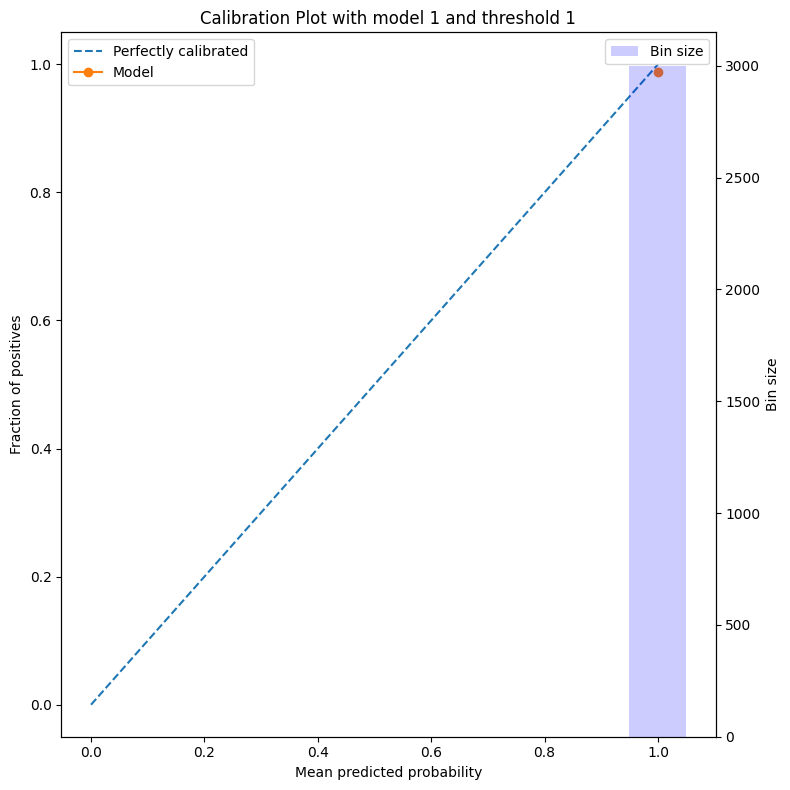

model=v_2; threshold=1
Brier Score: 0.01632580945288316
Components: Reliability=0.0002592538973276123, Resolution=0.0, Uncertainty=0.01606655555555555


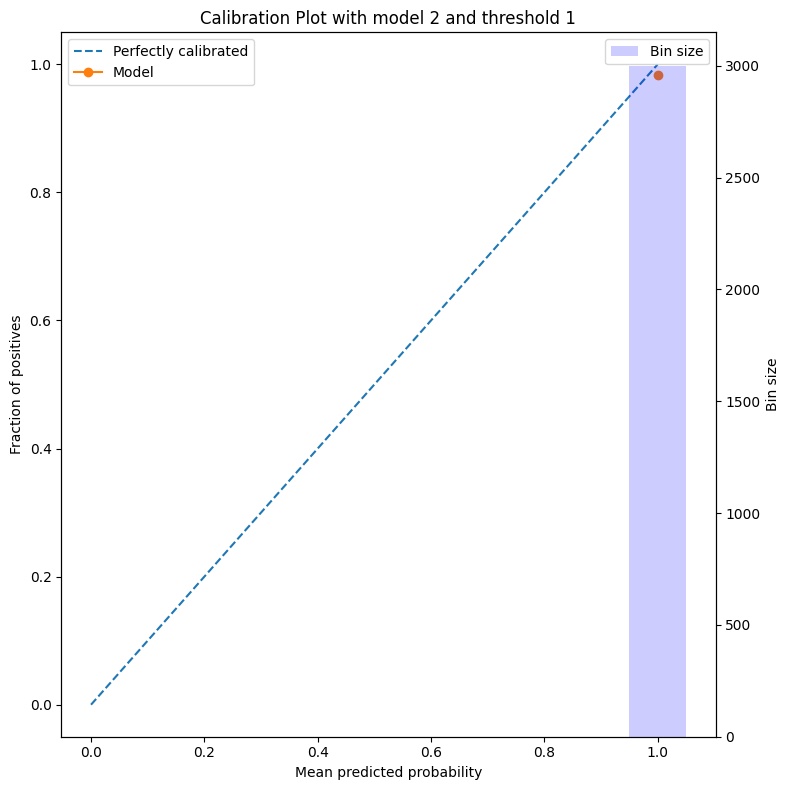

In [16]:
for model_version in range(1,3):
  brier_score_calibration(df_all, model_version, 1)